# HW04: RDD and Diff-in-Diff (due 26th October)

**You will have to solve only one of the two parts (either the RDD or the DiD) to get full credit for this homework.**

In this homework you will investigate the causal effect in two different settings, applying different **identification strategies**, You will also reflect and investigate the identification assumptions that allow for a causal interpretation. 

## Regression Discontinuity Design

In this first part you will use data on mayors from municipalities in Brazil to invesitgate th effect of electoral accountability on corruption. The goal is to estimate the effect of being eligible for reelection (having reelection incentives) on misappropriation of resources exploiting random audits on municipalities before the elections. In Brazil there is a two mandate limit for mayors, implying that only mayors in the first mandate can be reelected. The reference paper is [Ferraz and Finan (2011)](https://www.aeaweb.org/articles?id=10.1257/aer.101.4.1274).

In [3]:
from rdrobust import rdrobust, rdbwselect, rdplot
import pandas as pd 
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings = lambda *a, **kw: None


In [4]:
df = pd.read_stata('data/HW04_data_rdd.dta')

/var/folders/4l/50kz2_m54d53hffxvvphv1lr0000gn/T/ipykernel_62412/2619628620.py:1: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.


In [5]:
df_labels = pd.read_stata('data/HW04_data_rdd.dta', iterator=True).variable_labels()
df_labels

/var/folders/4l/50kz2_m54d53hffxvvphv1lr0000gn/T/ipykernel_62412/1581965592.py:1: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.


{'uf': 'state',
 'nsorteio': 'Número do sorteio',
 'totrecursos': 'Total de recurso fiscalizado no municipio',
 'tot_os': 'Total de OS fiscalizadas no municipio',
 'pop': 'População no ano de 2000',
 'purb': 'Proporção da população urbana no ano de 2000',
 'p_secundario': 'Proporção da população com 18 anos ou mais com secundario completo',
 'cod_ibge6': 'cod_ibge6',
 'pib_capita_02': 'PIB per capita deflacionado em reais de 2001',
 'op_01_04': 'Dummy se o munic teve orçamento participativo no periodo',
 'reeleito': 'Dummy de reeleição',
 'ENEP2000': '2000 ENEP',
 'ENLP2000': '2000 ENLP',
 'pref_idade_tse': 'Idade do prefeito',
 'comarca': 'Sede de Comarca',
 'reeleito_2004': 'Dummy dos candidatos que se reelegeram na eleição de 2004',
 'p_cad_pref': 'Proporção de vereadores eleitos do mesmo partido do prefeito',
 'rec_transf_correntes': '(mean) rec_transf_correntes',
 'gini_ipea': '',
 'fiscalizacoes': 'Total ordens de serviço dada pela planilha CGU',
 'valor_fiscalizado': 'Total orde

In [6]:
df = df[df['esample2']==1]
df.head()

,uf,nsorteio,totrecursos,tot_os,pop,purb,p_secundario,cod_ibge6,pib_capita_02,op_01_04,...,lfunc_ativ,lrec_fisc,ncorrupt,valor_corrupt,pcorrupt,dcorrupt,esample2,wm,winning_margin,party
0,RO,5,6913597.38,47.0,18207,0.815401,0.248250,566128.0,3548.000977,0,...,6.167517,15.749001,3.0,672785.125,0.097313,1.0,1.0,0.030935,-0.030935,16
1,RO,7,7135210.78,62.0,10459,0.198203,0.110925,566130.0,4203.421875,0,...,5.641907,15.780552,0.0,0.000,0.000000,0.0,1.0,0.172863,0.172863,3
2,RO,2,26821074.06,140.0,40884,0.649178,0.254702,566138.0,3904.267334,0,...,6.872128,17.104698,1.0,0.000,0.000000,1.0,1.0,0.310956,0.310956,18
3,RO,4,14710780.70,89.0,47382,0.726457,0.267212,566151.0,4081.257812,0,...,6.979145,16.504091,0.0,0.000,0.000000,0.0,1.0,0.391912,0.391912,18
4,RO,3,4181534.83,NaN,23874,0.271257,0.134546,566155.0,2192.473633,1,...,6.118097,15.246189,0.0,0.000,0.000000,0.0,1.0,0.186155,0.186155,14


The main outcome of interest is *pcorrupt*, namely, the share of audited resources found that involve corruption (a measure of misappropriation). The explanatory variable is *first*, a dummy variable indicating whether the mayor is in his first mandate. The regression of interest is the following: 
$$pcorrupt_i = \beta_0 + \beta_1 first_i + \varepsilon_i$$

In [8]:
## run the regression above using robust standard errors
import statsmodels.formula.api as smf 
from statsmodels.iolib.summary2 import summary_col


ols1 = smf.ols("pcorrupt ~ first", data = df).fit()
ols1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               pcorrupt   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     4.017
Date:                Tue, 25 Oct 2022   Prob (F-statistic):             0.0456
Time:                        17:22:36   Log-Likelihood:                 415.01
No. Observations:                 476   AIC:                            -826.0
Df Residuals:                     474   BIC:                            -817.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0737      0.007     10.428      0.000       0.060       0.088
first         -0.0188      0.009     -2.004      0.046      -0.037      -0.000
==============================================================================
Omnibus:                      318.592   Durbin-Watson:                   1.866
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3161.573
Skew:                           2.874   Prob(JB):                         0.00
Kurtosis:                      14.242   Cond. No.                         2.81
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**What could be some sources of bias, namely, variables that act as confounder?**

> Party affiliation could play a role if in that country some party are more likely to erode public institutions. 
> The proportion of people in favour of the candidate strongly influnce the chance of reelection and shoudl thus be take into account.  

In [13]:
## run the regression above adding the variables that may act as a confounder
ols2 = smf.ols("pcorrupt ~ first + p_cad_pref + party", data = df).fit()

In [14]:
## display the results 
ols2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               pcorrupt   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     1.747
Date:                Tue, 25 Oct 2022   Prob (F-statistic):             0.0265
Time:                        17:30:59   Log-Likelihood:                 429.72
No. Observations:                 476   AIC:                            -819.4
Df Residuals:                     456   BIC:                            -736.1
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0622      0.024      2.637      0.009       0.016       0.109
party[T.10]     0.0034      0.034      0.101      0.920      -0.063       0.070
party[T.11]     0.0202      0.022      0.916      0.360      -0.023       0.064
party[T.12]     0.0744      0.045      1.639      0.102      -0.015       0.164
party[T.13]    -0.0064      0.061     -0.105      0.917      -0.127       0.114
party[T.14]    -0.0110      0.034     -0.325      0.745      -0.078       0.056
party[T.15]     0.2818      0.102      2.756      0.006       0.081       0.483
party[T.16]     0.0311      0.028      1.102      0.271      -0.024       0.087
party[T.17]     0.0407      0.102      0.398      0.691      -0.160       0.242
party[T.18]     0.0403      0.022      1.810      0.071      -0.003       0.084
party[T.2]      0.0680      0.029      2.327      0.020       0.011       0.125
party[T.3]      0.0274      0.022      1.262      0.208      -0.015       0.070
party[T.4]      0.0398      0.024      1.664      0.097      -0.007       0.087
party[T.5]      0.0329      0.035      0.945      0.345      -0.035       0.101
party[T.6]      0.0465      0.102      0.456      0.649      -0.154       0.247
party[T.7]      0.2296      0.102      2.248      0.025       0.029       0.430
party[T.8]      0.0698      0.033      2.095      0.037       0.004       0.135
party[T.9]      0.0475      0.054      0.880      0.379      -0.059       0.153
first          -0.0248      0.010     -2.519      0.012      -0.044      -0.005
p_cad_pref     -0.0532      0.032     -1.676      0.095      -0.116       0.009
==============================================================================
Omnibus:                      325.202   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3672.768
Skew:                           2.895   Prob(JB):                         0.00
Kurtosis:                      15.315   Cond. No.                         31.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**In your opinion, are there any additional sources of bias that threatens the causal interpretation of the results?**

To make sure that this is not the case we will use a regression discontinuity design where the running variable is the margin by which the incumbent won or lost in the previous election. Namely, we compare municipalities where incumbents won or lost by a narrow margin. This comparison provides quasi-random assignment of first-term and second-term mayors across these competitive elections.

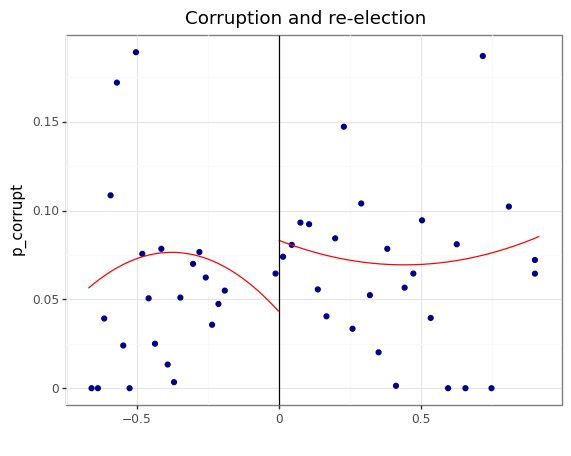


Call: rdplot
Number of Observations:                   328
Kernel:                               Uniform
Polynomial Order Est. (p):                  2

                                Left      Right
------------------------------------------------
Number of Observations           126        202
Number of Effective Obs          126        202
Bandwith poly. fit (h)         0.671      0.918
Number of bins scale               1          1
Bins Selected                     30         30
Average Bin Length             0.025      0.031
Median Bin Length              0.022      0.031
IMSE-optimal bins                5.0        3.0
Mimicking Variance bins         15.0       11.0

Relative to IMSE-optimal:
Implied scale                    6.0       10.0
WIMSE variance weight          0.005      0.001
WIMSE bias weight              0.995      0.999


In [17]:
## plot the RD plot using as running variable the variable winning_margin
## use a second order polynomial and 15 bins at each side

margin = df.dropna(subset=['winning_margin']).winning_margin
corruption = df.dropna(subset=['winning_margin']).pcorrupt


rdplot(y=corruption, x=margin, nbins=2*15, masspoints='adjust', p=2,
         title="Corruption and re-election", 
         y_label="p_corrupt",
         x_label=" ")

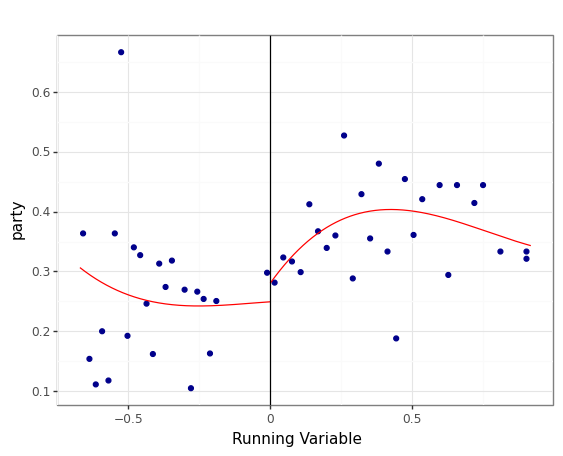


Call: rdplot
Number of Observations:                   328
Kernel:                               Uniform
Polynomial Order Est. (p):                  3

                                Left      Right
------------------------------------------------
Number of Observations           126        202
Number of Effective Obs          126        202
Bandwith poly. fit (h)         0.671      0.918
Number of bins scale               1          1
Bins Selected                     30         30
Average Bin Length             0.025      0.031
Median Bin Length              0.022      0.031
IMSE-optimal bins                6.0        7.0
Mimicking Variance bins          8.0       15.0

Relative to IMSE-optimal:
Implied scale                    5.0      4.286
WIMSE variance weight          0.008      0.013
WIMSE bias weight              0.992      0.987


In [43]:
## run the RD regression using the same dependent and explanatory variable as before
## include 4th degree polynomial and the covariates that you included above
cov_names = ["party", "p_cad_pref"]

#covs = [df[df.dropna(subset=['winning_margin'])['first'] == 1].party, df[df.dropna(subset=['winning_margin'])['first'] == 1].p_cad_pref]
#covs = pd.concat([df.dropna(subset=['winning_margin'])[["party"]]], axis=1)
covs = pd.concat([df.dropna(subset=['winning_margin'])[["p_cad_pref"]]], axis=1)

rdplot(y=covs, x=margin, nbins=30, masspoints='adjust', p=3,
         title=" ", 
         y_label=cov_names[0],
         x_label="Running Variable")


   

**Interpret the coefficient**

> We can see that when accounting for covariates, the increase in corruption for re-elected politician is higher (even more if we discard the outlier datapoint on the left side).

## Difference-in-Differences

In this part you will use data from Argentina to investigate the causal effect of police on crime. Following the paper by [Di Tella and Schargrodsky (2004)](https://www.aeaweb.org/articles?id=10.1257/000282804322970733), you will exploit the follow-up of a terrorist attack tto the Jewish center in Buenos Aires in July 1994, after which all Jewish institution received police protection. This event induced a geographical allocation of police forces orthogonal to a crime regression allowing to isolate the causal effect of having more police in a neighborhood on a proxy for crime (car thefts), through a difference-in-differences analysis. 

In [ ]:
df = pd.read_stata('data/HW04_data_DiD.dta')
df_labels = pd.read_stata('data/HW04_data_DiD.dta', iterator=True).variable_labels()
df_labels

In [ ]:
df.head()

The main outcome of interest is *totrob*, the total number of car thefts (proxy for criminal activity). The main explanatory variable is a dummy variable indicating whether the there is a Jewish institution in the neighborhood **and** the observation is after July (*inst1p*). The main regression is the following: 

$$totrob_i = \beta_0 + \beta_1 inst1p_i + \varepsilon_i$$

In [ ]:
## Run the regression above with robust standard errors
import statsmodels.formula.api as smf

ols1 = ...

**Why this estimate CANNOT be interpreted as causal?**

In [ ]:
## Plot the time series of car thefts separately for blocks with and without a jewish institutions
## Add a vertical line indicating the terrorist attack 
import seaborn as sns
import matplotlib.pyplot as plt


**Does the parallel trend assumption hold?**

In [ ]:
##Run the regression above including month and block fixed effects
from linearmodels import PanelOLS
did = ...

In [ ]:
##show the results from both regressions

**Compare and interpret the results**